## Aim: Investigate the effect of non-stationarity on different Contextual Bandit algorithms.

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install -q boost
!apt-get -qq install libboost-program-options-dev zlib1g-dev libboost-python-dev -y
!pip install -q vowpalwabbit

In [3]:
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import random

In [4]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

def get_cost(context,action,prob=0.0,iter_fraction=0.0):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

def get_cost_new0(context,action,prob=0.0,iter_fraction=0.0):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = f''
    example_string += f'shared |User user={context["user"]} time_of_day={context["time_of_day"]}\n'
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += f'0:{cost}:{prob} '
        example_string += f'|Action article={action} \n'
    return example_string[:-1]

In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

def plot_ctr_list(num_iterations, ctr_list, label_list, title):
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    for i,ctr in enumerate(ctr_list):
        plt.plot(range(1,num_iterations+1), ctr, label=f'{label_list[i]}')
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn=True):
    cost_sum = 0.
    ctr = []
    for i in range(1,num_iterations+1):
        user = choose_user(users)
        time_of_day = choose_time_of_day(times_of_day)
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)
        cost = cost_function(context, action, prob)
        cost_sum += cost

        if do_learn:
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            vw.learn(vw_format)
        ctr.append(-1*cost_sum/i)
    return ctr

def get_preference_matrix(cost_fun, iter_fraction=1.0):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2], iter_fraction=iter_fraction), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [10]:
get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

### Scenario #2

To make the multi-armed bandit scenario non-stationary with multiple changes, we change the reward depending on the fraction of iterations that have completed. For this simulation we make changes after every 25% of completed iterations. To stay consistent with Scenario #2, we use the original cost function first and then switch to the multiple change cost function. The modification is in the `*get_cost_new1*` function.

In [11]:
def get_cost_new1(context,action,prob=0.0,iter_fraction=1.0):
    #1: Add multiple changes to reward distribution over time.
    if iter_fraction <= 0.25:
        USER_LIKED_ARTICLE = -1.05
        USER_DISLIKED_ARTICLE = -0.5
    elif iter_fraction <= 0.5:
        USER_LIKED_ARTICLE = -0.5
        USER_DISLIKED_ARTICLE = 0.5
    elif iter_fraction <= 0.75:
        USER_LIKED_ARTICLE = -0.1
        USER_DISLIKED_ARTICLE = 0.0
    else:
        USER_LIKED_ARTICLE = -1.0
        USER_DISLIKED_ARTICLE = 0.0

    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [12]:
get_preference_matrix(get_cost_new1, iter_fraction=0.25) # Reward distribution upto 25% of num_iterations.

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon        -0.5     -0.5  -0.5    -0.5   -0.5     -0.50   -1.05
      morning          -0.5     -0.5  -0.5    -0.5   -0.5     -0.50   -1.05
Tom   afternoon        -0.5     -0.5  -0.5    -0.5   -0.5     -0.50   -1.05
      morning          -0.5     -0.5  -0.5    -0.5   -0.5     -1.05   -0.50

In [13]:
get_preference_matrix(get_cost_new1, iter_fraction=1.0) # Reward distribution for 75% -100% of num_iterations.

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
Tom   afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0

In addition, to add varying noise to the reawrd distribution, we must not be completely random with large changes as the bandit may not be able to utilize the context and policies to converge. We thus add a probabilistic modification by only allowing changes when the probability of the chosen action is less than a random probability value. The modification is in the `get_cost_new2` function.

In [14]:
def get_cost_new2(context,action,prob=0.3,iter_fraction=0.0):
    if prob > np.random.random():
        #2: Introduce varying noise to the reward distribution
        USER_LIKED_ARTICLE = -1.0 + np.random.randint(-100,100)/100.
        USER_DISLIKED_ARTICLE = 0.0 + np.random.randint(-100,100)/100.
    else:
        USER_LIKED_ARTICLE = -1.0
        USER_DISLIKED_ARTICLE = 0.0

    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

Notice the noise added to the reward distribution resembles a noisy label version of Scenario 3.

In [15]:
get_preference_matrix(get_cost_new2)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon        0.00     0.16 -0.62     0.0   0.00      0.62   -1.06
      morning          0.00     0.00  0.00     0.0   0.00      0.00   -1.00
Tom   afternoon        0.49     0.00  0.74     0.0   0.56      0.96   -1.00
      morning          0.00     0.00  0.53     0.0   0.00     -1.00    0.00

In [16]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn=True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            iteration = i/(end_counter + end_counter)
            cost = cost_function(context, action, prob, iteration)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [17]:
def train_bandits(num_iterations=5000, mode='Default'):
    vw1 = pyvw.vw("--cb_explore_adf -q UA --quiet --first 8")
    vw2 = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
    vw3 = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")
    vw4 = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")
    vw5 = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025")
    vw6 = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 4 --psi 0.1 --nounif TRUE")

    if mode == 'Multiple':
        # Multiple changes to the reward distribution over time.
        cost_functions = [get_cost, get_cost_new1]

    elif mode == 'Noise':
        # Varying noise to the reward distribution.
        cost_functions = [get_cost, get_cost_new2] 
        
    else:
        cost_functions = [get_cost, get_cost_new0] # Default

    num_iterations_per_cost_func = num_iterations
    total_iterations = num_iterations_per_cost_func * len(cost_functions)
    ctr1 = run_simulation_multiple_cost_functions(vw1, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
    ctr2 = run_simulation_multiple_cost_functions(vw2, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
    ctr3 = run_simulation_multiple_cost_functions(vw3, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
    ctr4 = run_simulation_multiple_cost_functions(vw4, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
    ctr5 = run_simulation_multiple_cost_functions(vw5, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)
    ctr6 = run_simulation_multiple_cost_functions(vw6, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

    ctr = [ctr1, ctr2, ctr3, ctr4, ctr5, ctr6]
    label_list = ['--first 8', '--epsilon 0.2', '--bag 5', '--softmax --lambda 10', '--rnd 3 --epsilon 0.025', '--cover 4 --psi 0.1 --nounif TRUE']
    title = f'Visualizing different exploration algorithms for content personalization. [{mode}]'
    plot_ctr_list(total_iterations, ctr, label_list, title)

### Default Scenario 2 
visualization of the performance of different exploration algorithms.

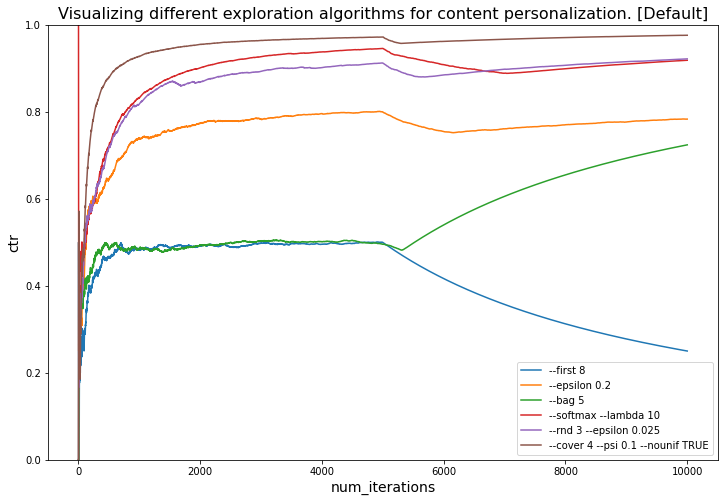

In [26]:
train_bandits(5000, mode='Default')

### **Add multiple changes to the reward distribution over time.**
We train for 2x the epochs to get a better visualization of the convergence of the different exploratory algorithms. The first 10k epochs corresponds to the default cost function and then we switch to the multiple changes cost function. Some iterations showed good performance with the `Online Cover` algorithm while other simulations showed good convergence with the `RND Explorer` or `Softmax Explorer`.  
  
(Note: The Github wiki stated that the implementation of online cover algorithm is not supported for `--cb_explore_adf`)

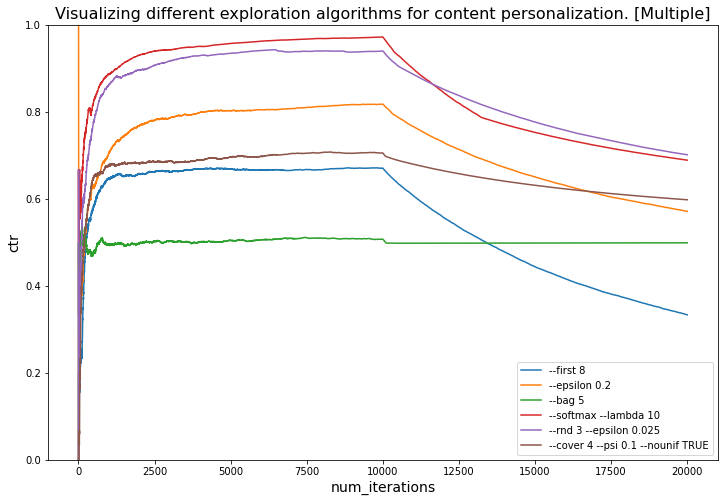

In [22]:
train_bandits(10000, mode='Multiple')

### **Introducing varying noise in the reward distribution.**
We introduce noise in the reward distribution based on the probability of the arm's action and sometimes this may lead to the original reward distribution. Adding larger noise values hindered learning and hence we do not allow the liked reward to be positive. 

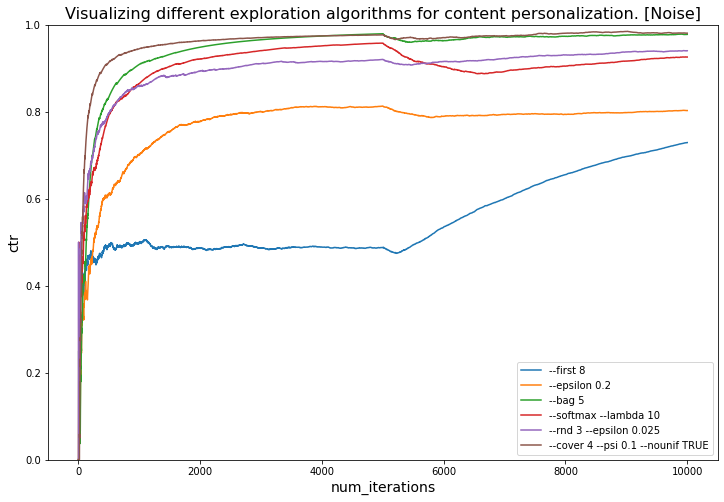

In [24]:
train_bandits(5000, mode='Noise')

### Analysis of results
When the reward distribution changes with time, the **maximum reward can be obtained with continued exploration for the associative search**. Gradient bandits are a good fit for such non-stationarity as they maintain an exponentially decaying reward estimate rather than scaling by the iteration. For the above case, we explore the effects of non-stationarity on different exploratory algorithms.